## Новый код

In [271]:
import datetime
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torch.nn as nn

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

import cv2
from keras.utils import to_categorical

import PIL.Image

from os.path import join as pjoin
import os

from tqdm import tqdm

In [195]:
now = datetime.datetime.now()
model_name = f'model_{now.strftime("%d%m_%H%M")}'

In [196]:
print(model_name)

model_0107_0327


In [197]:
python_seed = 245
np_seed = 123
torch_seed = 321
torch_cuda_seed = 111

In [198]:
torch.use_deterministic_algorithms(True)

In [199]:
random.seed(python_seed)
np.random.seed(np_seed)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_cuda_seed)


### Create train and val datasets

In [200]:
step = 30
im_shape=(401,701)
split_test=0.15
iline, xline = im_shape
vert_locations = np.arange(0, iline, step)
horz_locations = np.arange(0, xline, step)

In [201]:
vert_mask = np.array(vert_locations) // step % round(1 / split_test) == 0
horz_mask = np.array(horz_locations) // step % round(1 / split_test) == 0
p_tr_list = ['i_' + str(ii) for ii in vert_locations[~vert_mask]] + ['x_' + str(ii) for ii in horz_locations[~horz_mask]]
p_vl_list = ['i_' + str(ii) for ii in vert_locations[vert_mask]] + ['x_' + str(ii) for ii in horz_locations[horz_mask]]

In [202]:
vert_mask

array([ True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False])

In [203]:
random.shuffle(p_tr_list)
random.shuffle(p_vl_list)

In [204]:
len(p_tr_list), len(p_vl_list)

(32, 6)

In [205]:
path_data = 'data'

In [206]:
path_splits = pjoin(path_data, 'splits')
    
if not os.path.exists(path_splits):
    os.makedirs(path_splits)

In [207]:
file_object = open(pjoin(path_splits, 'train.txt'), 'w')
file_object.write('\n'.join(p_tr_list))
file_object.close()

file_object = open(pjoin(path_splits, 'val.txt'), 'w')
file_object.write('\n'.join(p_vl_list))
file_object.close()

### Сохраняем пример снимка и меток

In [208]:
# seismic = np.load(pjoin(path_data,'train','train_seismic.npy'))
# labels  = np.load(pjoin(path_data,'train','train_labels.npy' ))
# np.save('seismic_example_i.npy', seismic[131])
# np.save('labels_example_i.npy', labels[131])
# np.save('seismic_example_i_1.npy', seismic[-43])
# np.save('labels_example_i_1.npy', labels[-43])

# np.save('seismic_example_x.npy', seismic[:,246])
# np.save('labels_example_x.npy', labels[:,246])
# np.save('seismic_example_x_1.npy', seismic[:,-23])
# np.save('labels_example_x_1.npy', labels[:,-23])

### Трансформация (кроп) torchvision transforms

In [209]:
rand_crop_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=1, padding_mode='edge'),
    transforms.RandomCrop(256),
    transforms.RandomVerticalFlip(p=0.5)
])

#### Проверка трансформации

In [210]:
seismic_example_i = np.load('seismic_example_i.npy')
labels_example_i = np.load('labels_example_i.npy')
labels_cat_example_i = to_categorical(labels_example_i, num_classes=6)

seismic_example_i_1 = np.load('seismic_example_i_1.npy')
labels_example_i_1 = np.load('labels_example_i_1.npy')
labels_cat_example_i_1 = to_categorical(labels_example_i_1, num_classes=6)

In [211]:
seismic_example_x = np.load('seismic_example_x.npy')
labels_example_x = np.load('labels_example_x.npy')
labels_cat_example_x = to_categorical(labels_example_x, num_classes=6)

seismic_example_x_1 = np.load('seismic_example_x_1.npy')
labels_example_x_1 = np.load('labels_example_x_1.npy')
labels_cat_example_x_1 = to_categorical(labels_example_x_1, num_classes=6)

In [212]:
labels_cat_example_i.shape

(701, 255, 6)

In [213]:
np.expand_dims(seismic_example_i, axis=-1).shape

(701, 255, 1)

In [214]:
stacked = np.dstack([np.expand_dims(seismic_example_i, axis=-1), labels_cat_example_i])
stacked = rand_crop_1(stacked)
im, lbl = stacked[0], stacked[1:]
print(im.shape, lbl.shape)

torch.Size([256, 256]) torch.Size([6, 256, 256])


In [215]:
lbl[lbl % 1 != 0] #.round().int()

tensor([], dtype=torch.float64)

In [216]:
np.argmax(lbl, axis=0)

tensor([[0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        ...,
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5]])

In [217]:
seismic_arr_i = np.array([seismic_example_i, seismic_example_i_1])
labels_cat_arr_i = np.array([labels_cat_example_i, labels_cat_example_i_1])

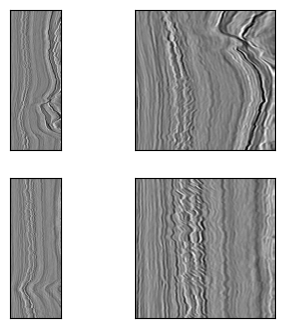

In [289]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(seismic_arr_i):
    axs[i][0].imshow(image, cmap='gray')
    axs[i][1].imshow(rand_crop_1(image).permute(1,2,0), cmap='gray')
for i in range(2):
    for j in range(2):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

In [219]:
# нарисовать через opencv привязать метки к классам

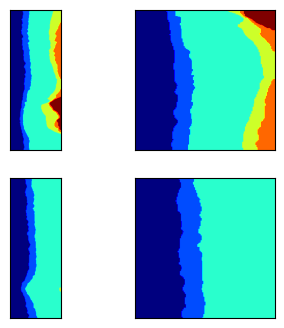

In [288]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(labels_cat_arr_i):
    axs[i][0].imshow(np.argmax(image,axis =-1), cmap='jet', vmin=0, vmax=5)
    axs[i][1].imshow(np.argmax(rand_crop_1(image).permute(1,2,0), axis=-1), cmap='jet', vmin=0, vmax=5)

for i in range(2):
    for j in range(2):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

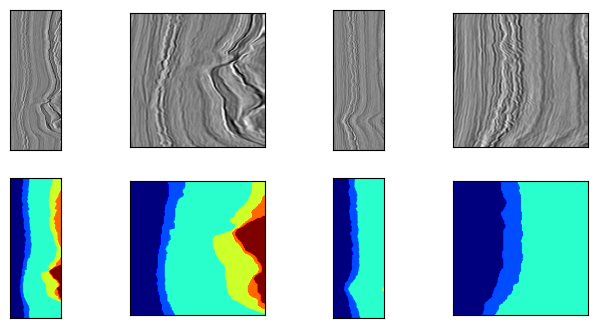

In [287]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
for i, image in enumerate(seismic_arr_i):
    stacked = np.dstack([np.expand_dims(image, axis=-1), labels_cat_arr_i[i]])
    stacked = rand_crop_1(stacked)
    im, lbl = stacked[0], stacked[1:]
    axs[0][2*i].imshow(image, cmap='gray')
    axs[0][2*i+1].imshow(im, cmap='gray')
    axs[1][2*i].imshow(np.argmax(labels_cat_arr_i[i], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[1][2*i+1].imshow(np.argmax(lbl.permute(1,2,0), axis=-1), cmap='jet', vmin=0, vmax=5)
    for j in range(2):
        axs[j][2*i].xaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i].yaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i+1].xaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i+1].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

### Делаем загрузчик данных

In [222]:
class MyDataset(Dataset):
    def __init__(self, split='train', loc='data/', transform = None):
        self.root = loc
        self.split = split
        self.n_classes = 6 
        self.transform = transform

        self.seismic = np.load(pjoin(self.root,'train','train_seismic.npy'))
        # seismic.shape = (701, 401, 255)
        self.labels  = np.load(pjoin(self.root,'train','train_labels.npy'   ))
        # labels.shape = (701, 401, 255)
        self.labels  = to_categorical(self.labels,num_classes=self.n_classes)
        # seismic.shape = (701, 401, 255, 6)

        path = pjoin(self.root, 'splits', self.split + '.txt')
        patch_list = tuple(open(path, 'r'))
        self.patch_list = patch_list

    def __len__(self):
        return len(self.patch_list)
    
    def __getitem__(self, index):
        indexes = self.patch_list[index]
        direction, number = indexes.split(sep='_')
        
        if direction == 'i':
            im = self.seismic[int(number),:,:]
            lbl = self.labels[int(number),:,:,:]
        elif direction == 'x':    
            im = self.seismic[:,int(number),:]
            lbl = self.labels[:,int(number),:,:]
        # im.shape = (701 or 401, 255)
        # lbl.shape = (701 or 401, 255, 6)

        assert im.shape[1] == 255 and lbl.shape[-1] == 6, f'wrong shapes: {im.shape} and {lbl.shape}'

        if self.transform:
            stacked = np.dstack([np.expand_dims(im, axis=-1), lbl])
            # stacked.shape = (701 or 401, 255, 7)
            stacked = rand_crop_1(stacked)
            # stacke.shape = torch.Size([7, 256, 256])
            im, lbl = stacked[0], stacked[1:]
            # im.shape = torch.Size([256, 256])
            # lbl.shape = torch.Size([6, 256, 256])

        if isinstance(im, np.ndarray):
            im = torch.from_numpy(im)
        if isinstance(lbl, np.ndarray):
            lbl = torch.from_numpy(lbl)

        image_tensor = torch.unsqueeze(im, 0)
        image_tensor = image_tensor.float()
        label_tensor = lbl.float()
        # image_tensor.shape = torch.Size([1, 256, 256])
        # label_tensor.shape = torch.Size([6, 256, 256])

        return image_tensor, label_tensor

In [223]:
train_dataset = MyDataset(split='train', transform=rand_crop_1)
val_dataset = MyDataset(split='val', transform=rand_crop_1)

In [224]:
len(train_dataset), len(val_dataset)

(32, 6)

In [225]:
batch_size = 8
num_epochs = 60

In [226]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Проверка DataLoader-ов

In [227]:
image_tensor, label_tensor = next(iter(train_loader))
len(train_loader)

4

In [228]:
image_tensor.shape, label_tensor.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 6, 256, 256]))

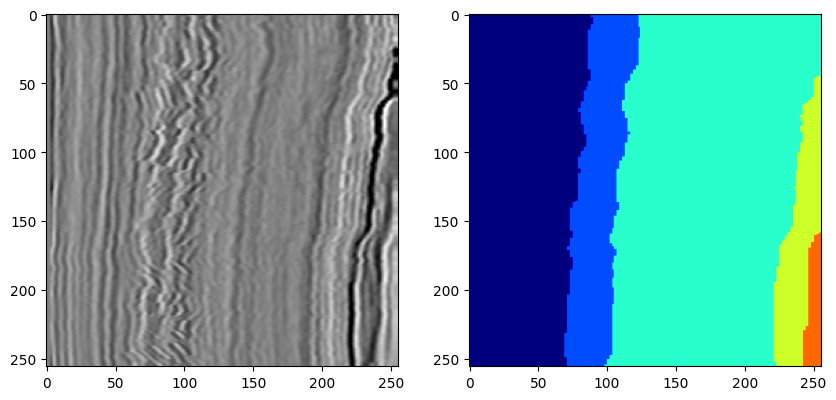

In [229]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axs[0].imshow(image_tensor[0,0,:,:], cmap='gray')
axs[1].imshow(np.argmax(label_tensor[0,:,:,:],axis=0), cmap='jet', vmin=0, vmax=5)
plt.show()

In [230]:
image_tensor.max(), image_tensor.min() # нормировка должна быть внутри класса

(tensor(1.), tensor(-1.))

### Моделька

In [231]:
# Создаем U-Net модель с энкодером resnet34
model = smp.Unet(
    encoder_name="resnet18", # resnet18 
    # encoder_weights="swsl", # можно обучать с нуля
    in_channels=1,
    classes=6  # Количество классов для сегментации
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Ravil/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:31<00:00, 1.49MB/s]


### Loss, merics, optimizer

In [232]:
# # Определяем функцию потерь и оптимизатор
loss = [smp.utils.losses.DiceLoss(), nn.CrossEntropyLoss()] # указать количество классов?
metrics = [smp.utils.metrics.IoU(threshold=0.7)] # threshold ?? 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# loss = [smp.losses.DiceLoss('multiclass'), smp.losses.SoftCrossEntropyLoss()]
# metrics = smp.metrics.iou_score

In [233]:
# Определяем устройство для обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [234]:
# Переносим модель и функцию потерь на устройство
model = model.to(device)
loss[0] = loss[0].to(device)
loss[1] = loss[1].to(device)

### Learning

#### Tensorboard settings

In [235]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(pjoin('models', model_name, 'runs'))

In [290]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # print(f'images.shape = {images.shape}')
    # print(f'output.shape = {output.shape}')
    
    output_soft = nn.functional.softmax(output, dim=1)
    probs_tensor, preds_tensor = torch.max(output_soft, 1)
    
    # print(f'probs_tensor.shape = {probs_tensor.shape}')
    # print(f'preds_tensor.shape = {preds_tensor.shape}')
    
    return probs_tensor, preds_tensor


def plot_classes_preds(net, images, labels, epoch, batch):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    probs, preds = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    batch_size = preds.shape[0]

    fig, axs = plt.subplots(nrows=3, ncols=batch_size, figsize=(10, 5))
    
    for idx in np.arange(batch_size):
        axs[0][idx].imshow(images[idx,0,:,:], cmap='gray')
        axs[1][idx].imshow(np.argmax(labels[idx],axis=0), cmap='jet', vmin=0, vmax=5)
        axs[2][idx].imshow(preds[idx], cmap='jet', vmin=0, vmax=5)
        for j in range(3):
            axs[j][idx].xaxis.set_major_locator(ticker.NullLocator())
            axs[j][idx].yaxis.set_major_locator(ticker.NullLocator())
    fig.set_layout_engine('tight')
    fig.suptitle(f'epoch #{epoch}, batch #{batch}')
    return fig

#### Training

In [237]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [238]:
len(train_loader), len(val_loader)

(4, 1)

In [239]:
if not os.path.exists(pjoin('models', model_name, 'disasters')):
    os.makedirs(pjoin('models', model_name, 'disasters'))

In [240]:
best_metric = 0
best_model = model

In [241]:
running_loss = 0.0

In [291]:
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    # Обучение
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # images.shape = torch.Size([batch_size, 1, 256, 256])
        # labels.shape = torch.Size([batch_size, 6, 256, 256])

        optimizer.zero_grad()
    
        outputs = nn.Softmax(dim=1)(model(images))
        # outputs.shape = torch.Size([batch_size, 6, 256, 256])

        loss_value = loss[0](outputs, labels.reshape(outputs.shape)) + loss[1](outputs, labels.reshape(outputs.shape))
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

        number_of_batches = len(train_loader)

        if i % number_of_batches == (number_of_batches - 1):    # every last batch

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / number_of_batches,
                            epoch * number_of_batches + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure(f'TRAIN: true vs pred',
                            plot_classes_preds(model, images, labels, epoch, i),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0

        if loss_value.item() < 0:
            np.save(pjoin('models', model_name, 'disasters', f'nl_output_{epoch}_{i}.npy'), outputs.detach().numpy())

    # Валидация
    model.eval()
    total_metric = 0
    num_samples = 0

    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        number_of_batches = len(val_loader)
        
        with torch.no_grad():
            outputs = nn.Softmax(dim=1)(model(images))
            # outputs.shape = torch.Size([batch_size, 6, 256, 256])
            
            # нужно ли делать argmax по классам? сделать свою метрику
            metric_value = metrics[0](outputs, labels.reshape(outputs.shape))
            total_metric += metric_value.item() * images.size(0)
            num_samples += images.size(0)
            
            if i % number_of_batches == (number_of_batches - 1):    # every last batch

                writer.add_figure(f'VALIDATION: true vs pred',
                    plot_classes_preds(model, images, labels, epoch, i),
                    global_step=epoch * len(val_loader) + i)
        
    average_metric = total_metric / num_samples

    writer.add_scalar('metrics',
        average_metric,
        epoch)
    
    # Вывод прогресса обучения
    # print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_value.item():.4f}, Metric: {average_metric:.4f}')

    # сохранение чекпойнта (если метрика стала лучше)
    if best_metric < average_metric:
        best_metric = average_metric
        best_model = model

Epochs:   0%|          | 0/60 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [243]:
best_metric

0.9640190601348877

In [244]:
last_model = model

In [246]:
torch.save(best_model.state_dict(), pjoin('models', model_name, f'{model_name}.pth'))

In [247]:
# model.load_state_dict(torch.load(pjoin('models', model_name, f'{model_name}.pth')))
# model = last_model

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
image_tensor, label_tensor = next(iter(train_loader))
output = nn.Softmax(dim=1)(best_model(image_tensor))
output = output.detach().numpy()
plt.imshow(np.argmax(output,axis=1)[0], cmap='jet', vmin=0, vmax=5)
plt.show()

### Тестируем на полном срезе

In [255]:
seismic_example_i_1.shape, labels_cat_example_i_1.shape

((701, 255), (701, 255, 6))

In [256]:
seismic_example_x_1.shape, labels_cat_example_x_1.shape

((401, 255), (401, 255, 6))

In [295]:
def test_i_sample(seismic_i, labels_cat_i, show_plots = False):
    resized_im = np.repeat(seismic_i, [(1 + i // 254) for i in range(255)], axis=1)
    resized_lbl = np.repeat(labels_cat_i, [(1 + i // 254) for i in range(255)], axis=1)

    im_parts = np.zeros((4, 256, 256))
    lbl_parts = np.zeros((4, 256, 256, 6))

    im_parts[0] = resized_im[0:256]
    im_parts[1] = resized_im[149:405]
    im_parts[2] = resized_im[298:554]
    im_parts[3] = resized_im[445:701]

    lbl_parts[0] = resized_lbl[0:256]
    lbl_parts[1] = resized_lbl[149:405]
    lbl_parts[2] = resized_lbl[298:554]
    lbl_parts[3] = resized_lbl[445:701]
    lbl_parts = np.moveaxis(lbl_parts, -1, 1)

    output_parts = np.zeros((4, 6, 256, 256))
    for i, output_part in enumerate(output_parts):
        _t = torch.from_numpy(np.expand_dims(np.expand_dims(im_parts[i], axis=0), axis=0)).float()
        # print(f'_t.shape = {_t.shape}')
        output_parts[i:i+1] = nn.Softmax(dim=1)(best_model(_t)).detach().numpy()
        # print(f'output_parts[i].shape = {output_parts[i].shape}')

    if show_plots:
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(6,3))
        for i, output_part in enumerate(output_parts):
            axs[0][i % 4].imshow(im_parts[i,:,:], cmap='gray')
            axs[1][i % 4].imshow(np.argmax(lbl_parts[i], axis=0), cmap='jet', vmin=0, vmax=5)
            axs[2][i % 4].imshow(np.argmax(output_part, axis=0), cmap='jet', vmin=0, vmax=5)
        for i in range(3):
            for j in range(4):
                axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
                axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
        plt.show()

    assert output_parts.shape == lbl_parts.shape, f'Shapes are not equal: {output_parts.shape} != {lbl_parts.shape}'
    full_output = np.zeros(resized_lbl.shape)
    output_parts = np.moveaxis(output_parts, 1, -1)

    full_output[0:149] = output_parts[0][0:149]
    full_output[149:256] = (output_parts[0][149:256] + output_parts[1][0:107]) / 2
    full_output[256:298] = output_parts[1][107:149]
    full_output[298:405] = (output_parts[1][149:256] + output_parts[2][0:107]) / 2
    full_output[405:445] = output_parts[2][107:147]
    full_output[445:554] = (output_parts[2][147:256] + output_parts[3][0:109]) / 2
    full_output[554:701] = output_parts[3][109:256]

    if show_plots:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,6))
        axs[0].imshow(resized_im[:,:255], cmap='gray')
        axs[1].imshow(np.argmax(resized_lbl[:,:255], axis=-1), cmap='jet', vmin=0, vmax=5)
        axs[2].imshow(np.argmax(full_output[:,:255], axis=-1), cmap='jet', vmin=0, vmax=5)
        for i in range(3):
            axs[i].xaxis.set_major_locator(ticker.NullLocator())
            axs[i].yaxis.set_major_locator(ticker.NullLocator())
        # print(resized_im.shape, resized_lbl.shape, full_output.shape)
        plt.show()
    return resized_im[:,:255], resized_lbl[:,:255], full_output[:,:255]

In [296]:
def test_x_sample(seismic_x, labels_cat_x, show_plots = False):
    resized_im = np.repeat(seismic_x, [(1 + i // 254) for i in range(255)], axis=1)
    resized_lbl = np.repeat(labels_cat_x, [(1 + i // 254) for i in range(255)], axis=1)

    im_parts = np.zeros((2, 256, 256))
    lbl_parts = np.zeros((2, 256, 256, 6))

    im_parts[0] = resized_im[0:256]
    im_parts[1] = resized_im[145:401]

    lbl_parts[0] = resized_lbl[0:256]
    lbl_parts[1] = resized_lbl[145:401]
    lbl_parts = np.moveaxis(lbl_parts, -1, 1)

    output_parts = np.zeros((2, 6, 256, 256))
    for i, output_part in enumerate(output_parts):
        _t = torch.from_numpy(np.expand_dims(np.expand_dims(im_parts[i], axis=0), axis=0)).float()
        output_parts[i:i+1] = nn.Softmax(dim=1)(best_model(_t)).detach().numpy()

    if show_plots:
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(6,3))
        for i, output_part in enumerate(output_parts):
            axs[0][i % 2].imshow(im_parts[i,:,:], cmap='gray')
            axs[1][i % 2].imshow(np.argmax(lbl_parts[i], axis=0), cmap='jet', vmin=0, vmax=5)
            axs[2][i % 2].imshow(np.argmax(output_part, axis=0), cmap='jet', vmin=0, vmax=5)
        for i in range(3):
            for j in range(2):
                axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
                axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
        plt.show()

    assert output_parts.shape == lbl_parts.shape, f'Shapes are not equal: {output_parts.shape} != {lbl_parts.shape}'
    full_output = np.zeros(resized_lbl.shape)
    output_parts = np.moveaxis(output_parts, 1, -1)

    full_output[0:145] = output_parts[0][0:145]
    full_output[145:256] = (output_parts[0][145:256] + output_parts[1][0:111]) / 2
    full_output[256:401] = output_parts[1][111:256]
    
    if show_plots:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,6))
        axs[0].imshow(resized_im[:,:255], cmap='gray')
        axs[1].imshow(np.argmax(resized_lbl[:,:255], axis=-1), cmap='jet', vmin=0, vmax=5)
        axs[2].imshow(np.argmax(full_output[:,:255], axis=-1), cmap='jet', vmin=0, vmax=5)
        for i in range(3):
            axs[i].xaxis.set_major_locator(ticker.NullLocator())
            axs[i].yaxis.set_major_locator(ticker.NullLocator())
        # print(resized_im.shape, resized_lbl.shape, full_output.shape)
        plt.show()
    return resized_im[:,:255], resized_lbl[:,:255], full_output[:,:255]

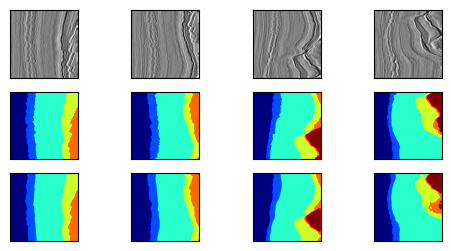

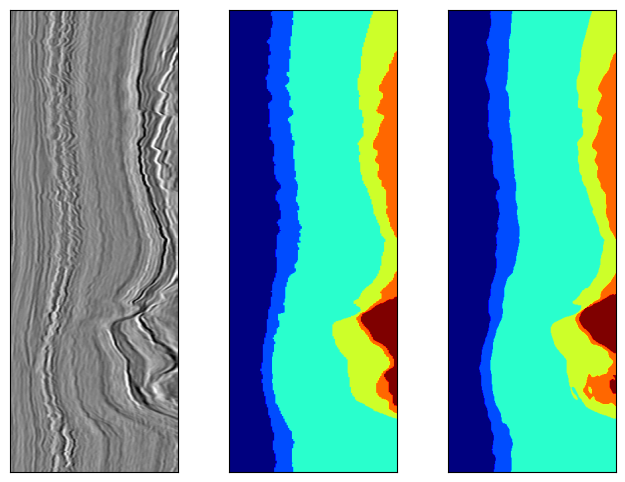

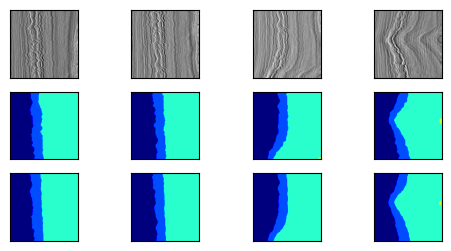

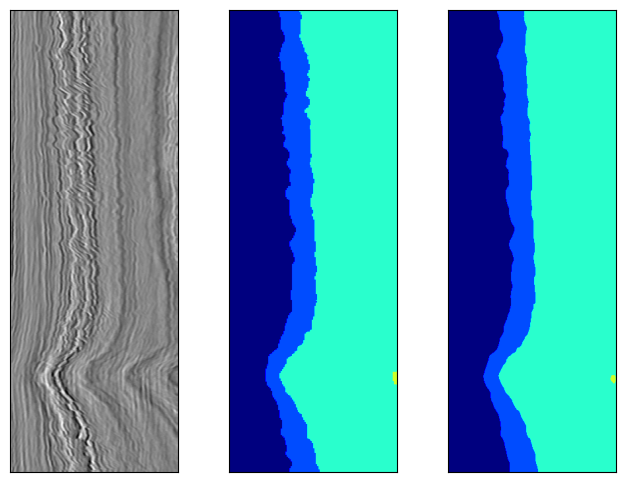

In [279]:
test_i_sample(seismic_example_i, labels_cat_example_i)
test_i_sample(seismic_example_i_1, labels_cat_example_i_1)

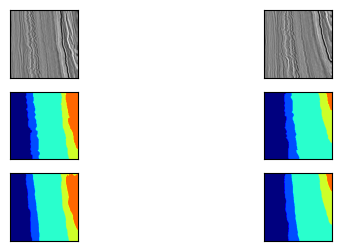

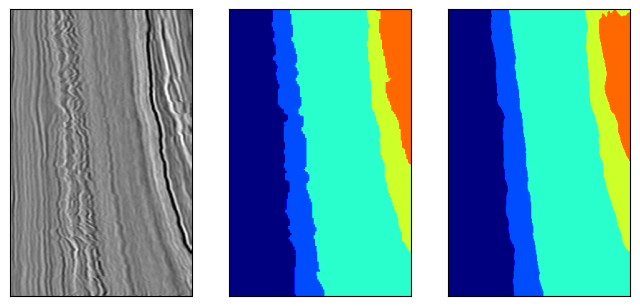

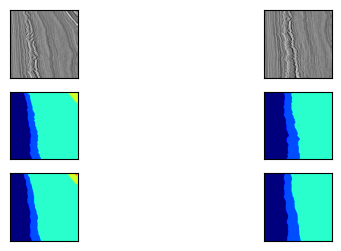

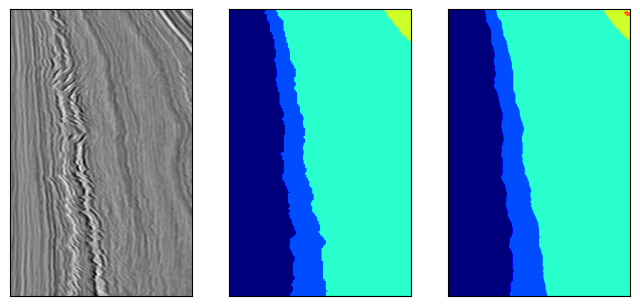

In [280]:
test_x_sample(seismic_example_x, labels_cat_example_x)
test_x_sample(seismic_example_x_1, labels_cat_example_x_1)

### Тестируем на всех срезах i и x

In [299]:
seismic = np.load(pjoin(path_data,'train','train_seismic.npy'))
labels  = np.load(pjoin(path_data,'train','train_labels.npy' ))

In [300]:
data_shape = seismic.shape

In [306]:
pred_labels_cat_i = np.zeros((data_shape[0], data_shape[1], data_shape[2], 6))

In [307]:
for i in range(data_shape[0]):
    im = seismic[i]
    lbl = to_categorical(labels[i], num_classes=6)
    _, lbl_cat, pred_lbl_cat = test_i_sample(im, lbl)
    pred_labels_cat_i[i] = pred_lbl_cat

In [310]:
pred_labels_cat_x = np.zeros((data_shape[0], data_shape[1], data_shape[2], 6))

In [311]:
for i in range(data_shape[1]):
    im = seismic[:,i]
    lbl = to_categorical(labels[:,i], num_classes=6)
    _, lbl_cat, pred_lbl_cat = test_x_sample(im, lbl)
    pred_labels_cat_x[:,i,:,:] = pred_lbl_cat

In [312]:
np.save(pjoin('models', model_name, 'pred_labels_cat_i.npy'), pred_labels_cat_i)
np.save(pjoin('models', model_name, 'pred_labels_cat_x.npy'), pred_labels_cat_x)

In [313]:
print(model_name)

model_0107_0327


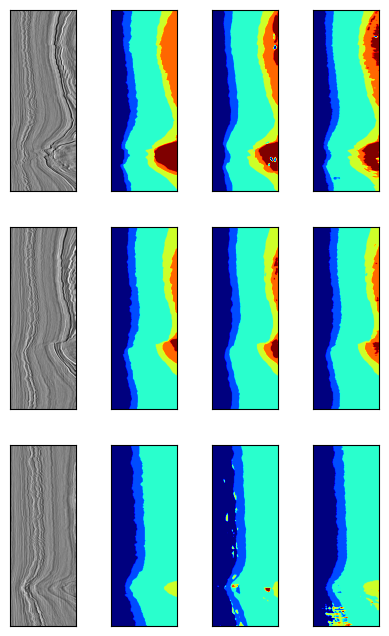

In [319]:
i_slices = [33, 156, 366]
fig, axs = plt.subplots(nrows=len(i_slices), ncols=4, figsize=(6, 8))
for i, idx in enumerate(i_slices):
    axs[i][0].imshow(seismic[idx], cmap='gray')
    axs[i][1].imshow(labels[idx], cmap='jet', vmin=0, vmax=5)
    axs[i][2].imshow(np.argmax(pred_labels_cat_i[idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[i][3].imshow(np.argmax(pred_labels_cat_x[idx], axis=-1), cmap='jet', vmin=0, vmax=5)
for i in range(len(i_slices)):
    for j in range(4):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

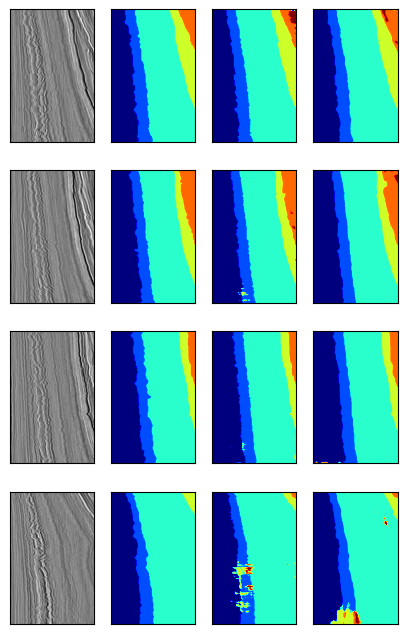

In [322]:
x_slices = [56, 236, 311, 666]
fig, axs = plt.subplots(nrows=len(x_slices), ncols=4, figsize=(6, 8))
for i, idx in enumerate(x_slices):
    axs[i][0].imshow(seismic[:,idx], cmap='gray')
    axs[i][1].imshow(labels[:,idx], cmap='jet', vmin=0, vmax=5)    
    axs[i][2].imshow(np.argmax(pred_labels_cat_i[:,idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[i][3].imshow(np.argmax(pred_labels_cat_x[:,idx], axis=-1), cmap='jet', vmin=0, vmax=5)
for i in range(len(x_slices)):
    for j in range(4):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

### Задачи


<!--
V фиксировать сиды для рандомов (numpy, torch)

V Добавить прямо в трансформ аугментацию с корректными параметрами
V    переделать рандом кроп 255 -> 256
V    добавить паддинг в рандом кроп, вместо ресайз(256х256) (проверить как работает паддинг)

V shuffle = True для DataLoader-ов

V наладить отображение графиков (cmap='jet', vmin=0, vmax=5)

правильно ли вычисляются метрики и лосс
    можно реализовать самому

V построить график изменения метрики, лосса

V softmax на выходе

V сохранять каждый первый батч в эпохах - проверить, что они отличаются (проверил и убрал)

проверить баланс классов 
    веса "классов"
    посчитать взвешенную функцию потерь, в зависимости от распределения по классам

построить распред IoU для всех 6 классов, чтобы посмотреть на каком из классов больше ошибок

почему плохо обучается?
    learning rate?
-->

In [298]:
# проверить работу лосса, метрик (функций)
#     1. взять какой-то сэмпл
#     2. посчитать с помощью функции
#     3. посчитать "ручками" по формуле
#     4. сравнить, добиться совпадения
#     5. что за threshold в diceloss?????????